# 方向预测模型

**思路**

1. 对于每一天，计算出下一天的涨跌方向，作为标签, 1表示涨，-1表示跌
2. 对于每一天，利用计算好的因子作为特征，训练一个二分类模型，预测涨跌方向，并存储在一个新变量里
3. 设置一个新的变量, 记录到该日期为止预测的准确率

**分类模型**
1. 随机森林
2. svm

在训练好模型之后，计算出feature importance


In [39]:
from 传统动量指标集 import *
from 传统波动率指标集 import *
from 国泰君安指标计算集 import *
from 世宽指标计算集 import *
import importlib
import pandas as pd
import 计算函数包
importlib.reload(计算函数包)
from tqdm.contrib.concurrent import process_map
from multiprocessing import Pool, cpu_count
from functools import partial
import 回测函数包
importlib.reload(回测函数包)
from 回测函数包 import *
import newbacktest
import 计算函数包 as cf


In [40]:
%matplotlib inline

In [41]:
# 首先计算因子


if __name__ == "__main__":
    feature_compute_funcs = [
        high_low_5days, high_low_17days,

        volume_std_2days, volume_std_11days, volume_std_21days,

        returns_std_3days, returns_std_27days, returns_last_5days, returns_last_18day, returns_last_2days,

        weighted_avg_return_2, weighted_avg_return_42,

        returns_daliy_max_2days, returns_daliy_max_7days, returns_daliy_max_last_20days,

        sma_weight_con_23_37, sma_weight_con_3_62,

        flipping_weight_29_69, flipping_weight_4_67,

        gj_001, gj_002, gj_003, gj_004, gj_005, gj_006, gj_007, gj_008, gj_009, gj_010,
        gj_011, gj_012, gj_013, gj_014, gj_015, gj_016, gj_017, gj_018, gj_019, gj_020,
        gj_021, gj_022, gj_023, gj_024, gj_025, gj_026, gj_027, gj_028, gj_029, gj_031,
        gj_032, gj_033, gj_034, gj_035, gj_036, gj_037, gj_038, gj_039, gj_040, gj_041,
        gj_042, gj_043, gj_044, gj_045, gj_046, gj_047, gj_048, gj_049, gj_050, gj_051,
        gj_052, gj_053, gj_054, gj_056, gj_057, gj_058, gj_059, gj_060, gj_061, gj_062,
        gj_063, gj_064, gj_065, gj_066,

        wq_001, wq_002, wq_003, wq_004, wq_005, wq_006, wq_007, wq_008, wq_009, wq_010,
        wq_011, wq_012, wq_013, wq_014, wq_015, wq_016, wq_017, wq_018, wq_019, wq_020,
        wq_021, wq_022, wq_023, wq_024, wq_025, wq_026, wq_027, wq_028, wq_029, wq_030,
        wq_031, wq_032, wq_033, wq_034, wq_035, wq_036, wq_037, wq_038, wq_039, wq_040,
        wq_041, wq_042, wq_043, wq_044, wq_045, wq_046, wq_047, wq_049, wq_050, wq_051,
        wq_052, wq_053, wq_054, wq_055, wq_057, wq_065, wq_064, wq_060, wq_061, wq_066,
        wq_068, wq_070, wq_071, wq_072, wq_073, wq_074, wq_075, wq_077, wq_078, wq_081,
        wq_083, wq_085
    ]
    # 读取因子名
    feature_names = [func.__name__ for func in feature_compute_funcs]
    df = pd.read_csv("/Users/wangyanbo/24Spring/intern/MLBasedFuturesStrategy/Dataset/指标已计算/dataset.csv")
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[df['huanyue'] != 1]
    df = df.loc[df['date'].dt.dayofweek != 4]
    print("已删除所有周五和所有换月日")


已删除所有周五和所有换月日


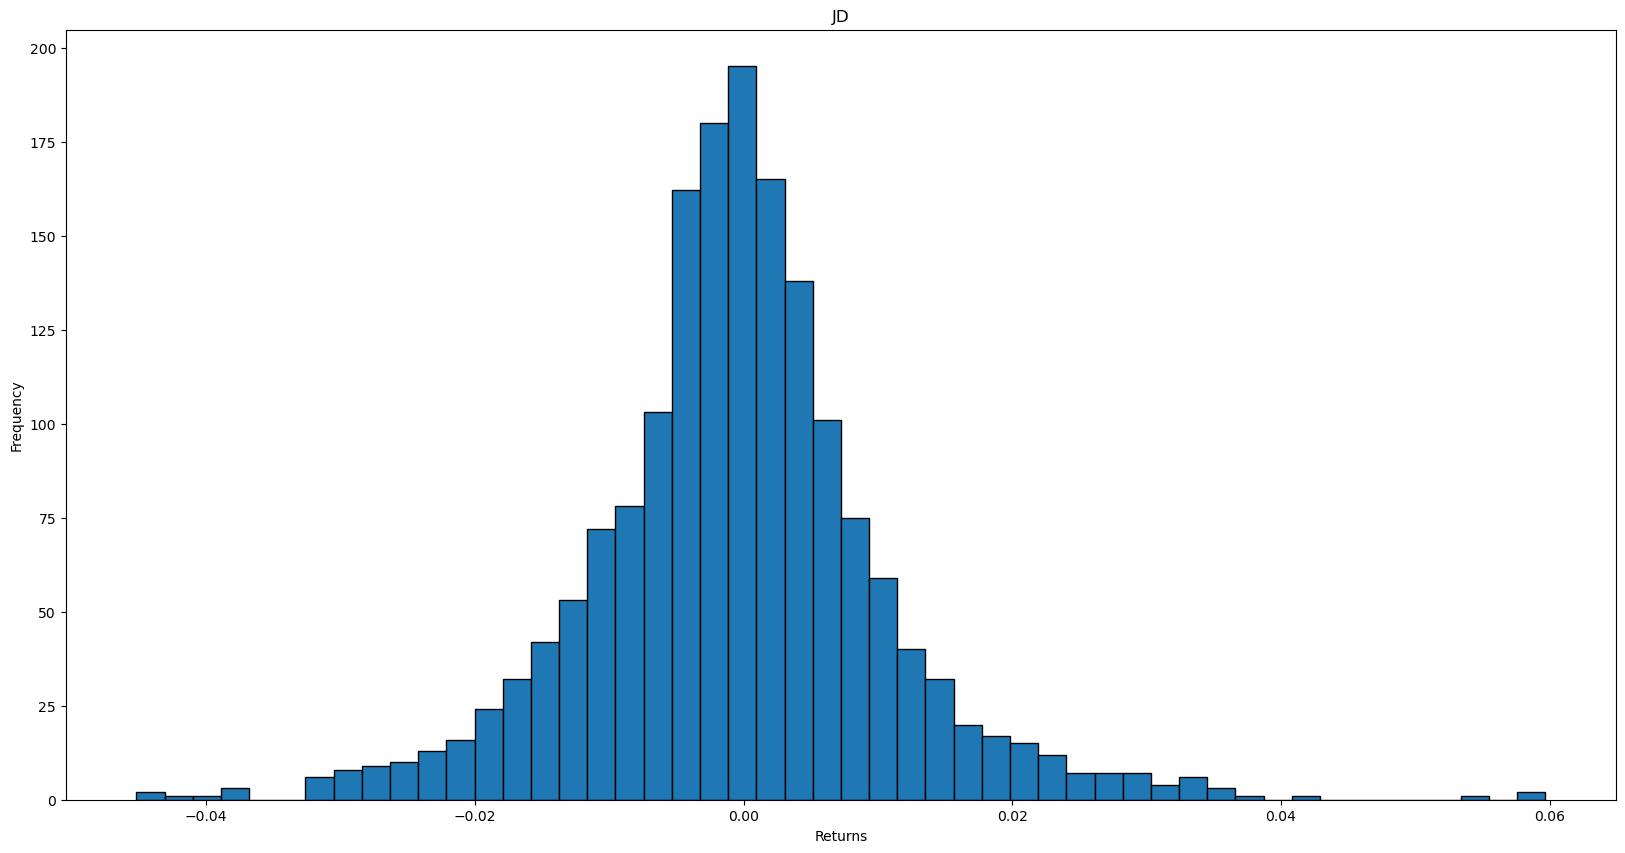

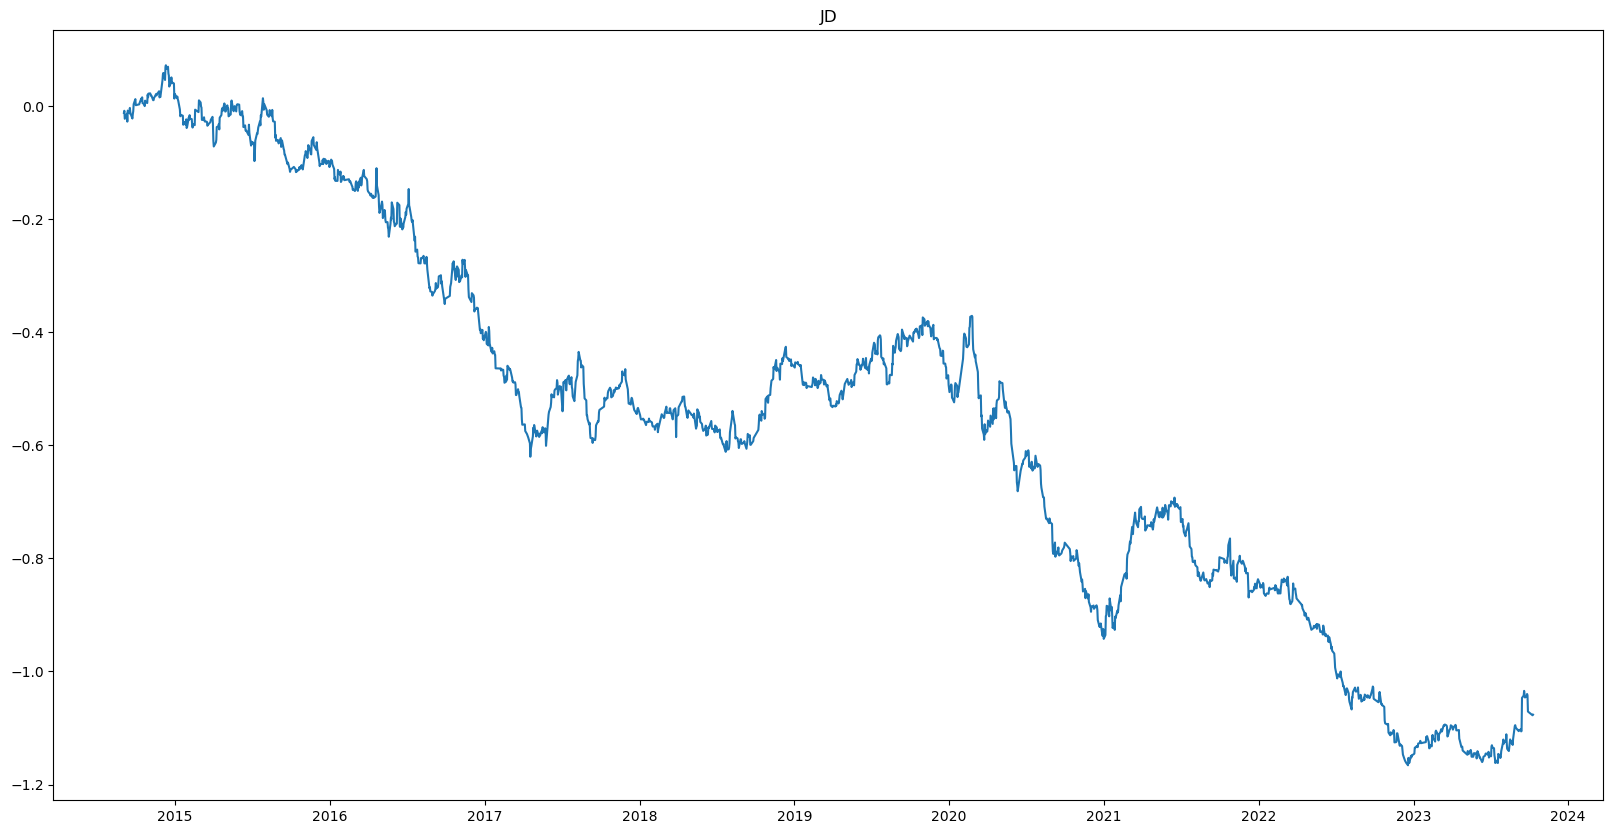

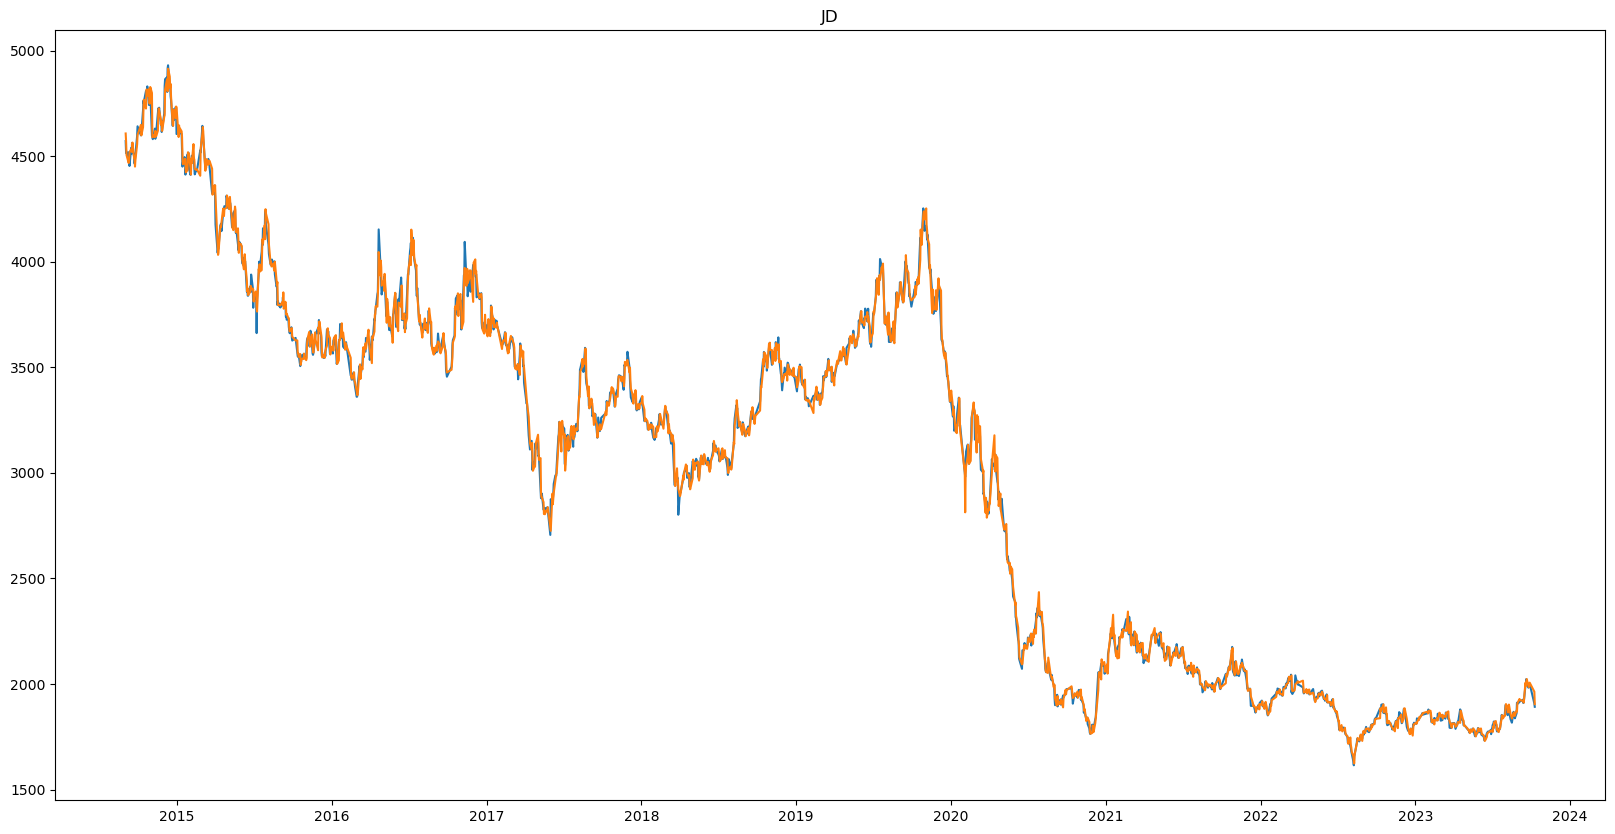

总涨幅为 -1.07644
上涨的概率为 0.4616947185142194
总变化为 13.5463


In [42]:
name = 'JD'
columns_0429 = ['date'] + ['id'] + ['returns'] + ['open', 'close']
df_transaction_subset = df[df['id'] == name][columns_0429]
df_transaction_subset = df_transaction_subset.sort_values('date')
df_transaction_subset = df_transaction_subset.reset_index(drop=True)
df_transaction_subset = df_transaction_subset.dropna()
df_transaction_subset['returns_sign'] = np.sign(df_transaction_subset['returns'])

# plot the distribution of the returns
# returns =  (df_transaction_subset['returns']**2)**0.4
returns = df_transaction_subset['returns']
# returns = df_transaction_subset['returns_sign'] * returns
plt.figure(figsize=(20, 10))
plt.hist(returns, bins=50, edgecolor='black')
plt.title(name)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(df_transaction_subset['date'], returns.cumsum())
plt.title(name)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(df_transaction_subset['date'], df_transaction_subset['close'])
plt.plot(df_transaction_subset['date'], df_transaction_subset['open'])
plt.title(name)
plt.show()

print("总涨幅为", df_transaction_subset['returns'].sum())
print("上涨的概率为", df_transaction_subset['returns_sign'].sum()/(len(df_transaction_subset['returns_sign']) * 2) + 0.5 )
print("总变化为", abs(df_transaction_subset['returns']).sum())



Test statistic: 0.9673671722412109
p-value: 2.663119872835778e-19
The distribution is likely not normal.


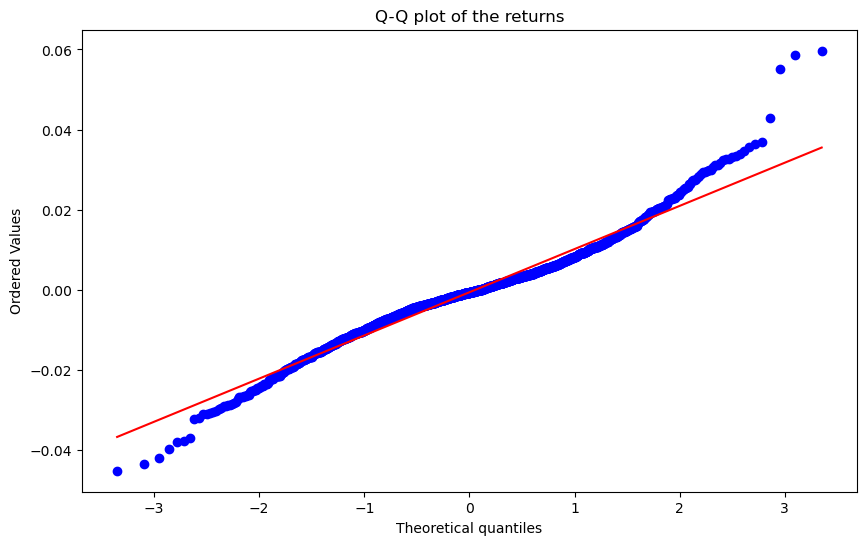

In [43]:
from scipy import stats

# Perform Shapiro-Wilk test
W, p = stats.shapiro(returns)
# Print the test statistic and p-value
print(f'Test statistic: {W}')
print(f'p-value: {p}')

# Check if the distribution is normal based on the p-value
if p > 0.05:
    print('The distribution is likely normal.')
else:
    print('The distribution is likely not normal.')


# Generate Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(returns, plot=plt)
plt.title('Q-Q plot of the returns')
plt.show()

# 数据预处理
1. 删除缺失值

In [44]:
# 对于给定name的期货进行训练
diction_model = []

name = 'JD'
results = []
# selected_features = features[name]
selected_features = feature_names
columns_to_extract = ['date'] + ['id'] + selected_features + ['returns']
df_subset = df[df['id'] == name][columns_to_extract]
df_subset = df_subset.sort_values('date')

df_subset['returns_sign'] = np.sign(df_subset['returns'])

# 删除缺失值
df_subset = df_subset.dropna(thresh=int(len(df_subset)*0.9), axis=1)
df_subset = df_subset.dropna()
df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_subset.fillna(method='ffill', inplace=True)
df_subset['prediction'] = 0
df_subset['prediction'] = df_subset['prediction'].astype(float)
returns_subset =  (df_subset['returns'] **2)**0.4
df_subset['returns'] = returns_subset * df_subset['returns_sign']

# 将数据前99%取出
threshold = int(0.99 * len(df_subset))
if threshold <= 287:
    # 如果某品种过往数据太少，这个品种将不参与运算
    print("当前品种交易数据太少")
    # continue
else:
    df_subset['label'] = np.where(df_subset.index.isin(df_subset.index[:287]), -1, 1)
    diction_model.append(df_subset)

# results.append(cf.linear_regression_rolling(df_subset, length=287))

sum_length = sum(len(item) for item in diction_model)
print("元素总数是:", sum_length)

元素总数是: 1436


In [45]:
# partial_function = partial(cf.svm_rolling, length=287)
# accuracy = []
# for a in np.arange(0.0001, 0.001, 0.00005):
#     partial_function = partial(cf.lasso_regression_classification, length=287, alpha=a)
#     results = process_map(partial_function, diction_model, max_workers=cpu_count()-1)
#     prediction = pd.concat(results, ignore_index=True)
#     prediction = prediction[prediction['label'] == 1]
#     selected_columns = ['date', 'id', 'prediction', 'returns_sign']
#     prediction_selected = prediction[selected_columns]
#     accuracy_1 = np.sum(prediction_selected['prediction'] == prediction_selected['returns_sign']) / len(prediction_selected)
#     print("accuracy is:", accuracy_1)
#     # print("number of prediction is 0:", np.sum(prediction_selected['prediction'] == 0))
#     accuracy.append(accuracy_1)
# partial_function = partial(cf.lasso_regression_classification, length=287, alpha)
# results = process_map(partial_function, diction_model, max_workers=cpu_count()-1)
# prediction = pd.concat(results, ignore_index=True)
# prediction = prediction[prediction['label'] == 1]
# selected_columns = ['date', 'id', 'prediction', 'returns_sign']
# prediction_selected = prediction[selected_columns]
# accuracy_1 = np.sum(prediction_selected['prediction'] == prediction_selected['returns_sign']) / len(prediction_selected)
# print("accuracy is:", accuracy_1)

# print("number of prediction is 0:", np.sum(prediction_selected['prediction'] == 0))


期现结合 of 鸡蛋品种
    鸡蛋的周期是哪里来的
航运指数的现货价格不透明。每周公布一次
- e.g.原油宝

In [46]:
%matplotlib inline

In [ ]:
# partial_function = partial(cf.lasso_regression_classification, length=287, alpha=0.0005)
partial_function = partial(cf.lasso_regression_classification, length=287, alpha=0.0001)
results = process_map(partial_function, diction_model, max_workers=cpu_count()-1)
prediction = pd.concat(results, ignore_index=True)
prediction = prediction[prediction['label'] == 1]
selected_columns = ['date', 'id', 'prediction', 'returns_sign']
prediction_selected = prediction[selected_columns]
accuracy = np.sum(prediction_selected['prediction'] 
                  == prediction_selected['returns_sign']) / len(prediction_selected)
print("accuracy is:", accuracy)

In [48]:
# partial_function = partial(cf.lasso_regression_classification, length=287, alpha=0.0005)
partial_function_1 = partial(cf.linear_regression_rolling, length=287)
results_1 = process_map(partial_function_1, diction_model, max_workers=cpu_count()-1)
prediction_1 = pd.concat(results_1, ignore_index=True)
prediction_1 = prediction_1[prediction_1['label'] == 1]
selected_columns = ['date', 'id', 'prediction', 'returns_sign']
prediction_selected_1 = prediction_1[selected_columns]
accuracy_1 = np.sum(np.sign(prediction_selected_1['prediction']) 
                    == prediction_selected_1['returns_sign']) / len(prediction_selected_1)
print("accuracy is:", accuracy_1)

  0%|          | 0/1 [00:00<?, ?it/s]

accuracy is: 0.9843342036553525


In [49]:
partial_function_2 = partial(cf.linear_regression_rolling_l, length=287)
results_2 = process_map(partial_function_2, diction_model, max_workers=cpu_count()-1)
prediction_2 = pd.concat(results_2, ignore_index=True)
prediction_2 = prediction_2[prediction_2['label'] == 1]
selected_columns = ['date', 'id', 'prediction', 'returns_sign']
prediction_selected_2 = prediction_2[selected_columns]
accuracy_2 = np.sum(np.sign(prediction_selected_2['prediction'])
                     == prediction_selected_2['returns_sign']) / len(prediction_selected_2)
print("accuracy is:", accuracy_2)

print("predicted going down:", np.sum(np.sign(prediction_selected_2['prediction']) == -1)/
      (np.sum(np.sign(prediction_selected_2['prediction']) == -1) + 
       np.sum(np.sign(prediction_selected_2['prediction']) == 1)))

print("real going down:", np.sum(prediction_selected_2['returns_sign'] == -1)/len(prediction_selected_2))

  0%|          | 0/1 [00:00<?, ?it/s]

accuracy is: 0.9834638816362054
predicted going down: 0.5335073977371627
real going down: 0.5265448215839861
